# All imports #

In [1]:
from __future__ import print_function

import sys, os

import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

from keras_uncertainty.models import MCDropoutClassifier, MCDropoutRegressor
from keras_uncertainty.utils import numpy_regression_nll


/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/d

In [2]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


In [3]:
##please select the appropriate folder, willl use os.path.join() for completed script
TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')
x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')
x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)

In [4]:

x_train_df = pd.DataFrame(x_train)
q_train_df = pd.DataFrame(q_train)
x_test_df = pd.DataFrame(x_test)
q_test_df = pd.DataFrame(q_test)


from sklearn.ensemble import IsolationForest


clf = IsolationForest(n_estimators=100, max_samples='auto', max_features=1, bootstrap=False, n_jobs= -1, random_state=42, verbose=0)
clf.fit(q_train_df)

pred = clf.predict(q_train_df)
q_train_df['anamoly'] = pred
print(q_train_df['anamoly'].value_counts())

InDistribution_Q_Train = q_train_df[q_train_df['anamoly'] == 1]
OutDistribution_Q_Train =   q_train_df[q_train_df['anamoly'] == -1]
InDistribution_X_Train =    x_train_df[q_train_df['anamoly'] == 1]
OutDistribution_X_Train =   x_train_df[q_train_df['anamoly'] == -1]

clf_test = IsolationForest(n_estimators=100, max_samples='auto', max_features=1, bootstrap=False, n_jobs= -1, random_state=42, verbose=0)
clf_test.fit(q_test_df)
pred_test = clf.predict(q_test_df)
q_test_df['anamoly'] = pred_test

InDistribution_Q_Test = q_test_df[q_test_df['anamoly'] == 1]
OutDistribution_Q_Test =q_test_df[q_test_df['anamoly'] == -1]
InDistribution_X_Test = x_test_df[q_test_df['anamoly'] == 1]
OutDistribution_X_Test =x_test_df[q_test_df['anamoly'] == -1]

x_train_1 = InDistribution_X_Train
q_train_1 = InDistribution_Q_Train.drop(['anamoly'], axis=1)
x_test_1 = InDistribution_X_Test
q_test_1 = InDistribution_Q_Test.drop(['anamoly'], axis=1)

OOD_x_train = OutDistribution_X_Train
OOD_q_train = OutDistribution_Q_Train.drop(['anamoly'], axis=1)
OOD_x_test = OutDistribution_X_Test
OOD_q_test = OutDistribution_Q_Test.drop(['anamoly'], axis=1)

q_test = q_test.drop(['anamoly'], axis=1)



/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


 1    14062
-1     1563
Name: anamoly, dtype: int64


/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [8]:
print(q_test_1.shape, q_train_1.shape, q_test.shape)
print(x_train_1.shape, OOD_x_train.shape, x_test_1.shape, OOD_x_test.shape)

(3790, 18) (14062, 18) (4096, 18)
(14062, 9) (1563, 9) (3790, 9) (306, 9)


# Building the model with MC Droput #

In [9]:
'''

Standard deviation based data splitting

We consider the Q features and use the feature with the 

highest SD for dividing the dataset
'''
'''
stats_q_train = pd.DataFrame()
stats_q_train["Mean"] = q_train.mean()
stats_q_train["Var"] = q_train.var()
stats_q_train["STD"] = q_train.std()
stats_q_train["OneSigmaMax"] = stats_q_train["Mean"] + stats_q_train["STD"]
stats_q_train["OneSigmaMin"] = stats_q_train["Mean"] - stats_q_train["STD"]
stats_q_train.T

max_std = stats_q_train["STD"].max()
colomn_max_std = stats_q_train["STD"].idxmax()

maximum = stats_q_train.loc[colomn_max_std, "Mean"] + (1.5 * max_std)
minimum = stats_q_train.loc[colomn_max_std, "Mean"] - (1.5 * max_std)
print(maximum, minimum)

InDistribution_Q_Train = q_train[q_train[colomn_max_std].le(maximum) & q_train[colomn_max_std].ge(minimum)]
OutDistribution_Q_Train = q_train[q_train[colomn_max_std].ge(maximum) | q_train[colomn_max_std].le(minimum)]
InDistribution_X_Train = x_train[q_train[colomn_max_std].le(maximum) & q_train[colomn_max_std].ge(minimum)]
OutDistribution_X_Train = x_train[q_train[colomn_max_std].ge(maximum) | q_train[colomn_max_std].le(minimum)]

InDistribution_Q_Test = q_test[q_test[colomn_max_std].le(maximum) & q_test[colomn_max_std].ge(minimum)]
OutDistribution_Q_Test = q_test[q_test[colomn_max_std].ge(maximum) | q_test[colomn_max_std].le(minimum)]
InDistribution_X_Test = x_test[q_test[colomn_max_std].le(maximum) & q_test[colomn_max_std].ge(minimum)]
OutDistribution_X_Test = x_test[q_test[colomn_max_std].ge(maximum) | q_test[colomn_max_std].le(minimum)]

x_train_1 = InDistribution_X_Train
q_train_1 = InDistribution_Q_Train
x_test_1 = InDistribution_X_Test
q_test_1 = InDistribution_Q_Test

OOD_x_train = OutDistribution_X_Train
OOD_q_train = OutDistribution_Q_Train
OOD_x_test = OutDistribution_X_Test
OOD_q_test = OutDistribution_Q_Test

print("//////////////////////")
print(x_train_1.shape, OOD_x_train.shape, x_test_1.shape, OOD_x_test.shape)
'''

'\nstats_q_train = pd.DataFrame()\nstats_q_train["Mean"] = q_train.mean()\nstats_q_train["Var"] = q_train.var()\nstats_q_train["STD"] = q_train.std()\nstats_q_train["OneSigmaMax"] = stats_q_train["Mean"] + stats_q_train["STD"]\nstats_q_train["OneSigmaMin"] = stats_q_train["Mean"] - stats_q_train["STD"]\nstats_q_train.T\n\nmax_std = stats_q_train["STD"].max()\ncolomn_max_std = stats_q_train["STD"].idxmax()\n\nmaximum = stats_q_train.loc[colomn_max_std, "Mean"] + (1.5 * max_std)\nminimum = stats_q_train.loc[colomn_max_std, "Mean"] - (1.5 * max_std)\nprint(maximum, minimum)\n\nInDistribution_Q_Train = q_train[q_train[colomn_max_std].le(maximum) & q_train[colomn_max_std].ge(minimum)]\nOutDistribution_Q_Train = q_train[q_train[colomn_max_std].ge(maximum) | q_train[colomn_max_std].le(minimum)]\nInDistribution_X_Train = x_train[q_train[colomn_max_std].le(maximum) & q_train[colomn_max_std].ge(minimum)]\nOutDistribution_X_Train = x_train[q_train[colomn_max_std].ge(maximum) | q_train[colomn_max_

In [10]:

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

#In order training set
x_train_1 = x_scaler.fit_transform(x_train_1)
q_train_1 = q_scaler.fit_transform(q_train_1)

#complete test set
x_test = x_scaler.transform(x_test)
#q_test = q_scaler.transform(q_test)

#split testing data
IOD_x_test = x_scaler.transform(x_test_1)
IOD_q_test = q_scaler.transform(q_test_1)

OOD_x_test = x_scaler.transform(OOD_x_test)
OOD_q_test = q_scaler.transform(OOD_q_test)

In [11]:
def model_builder(input_shape, output_shape):
    def build_model(depth, width, reduction_factor):
        model = Sequential()

        for i in range(depth):
            num_neurons = max(int(width * (reduction_factor ** i)), 4)
            if i == 0:
                model.add(Dense(num_neurons, activation='relu', input_shape=(input_shape,)))
            else:
                model.add(Dropout(0.5))
                model.add(Dense(num_neurons, activation='relu'))
                

            model.add(BatchNormalization())

        model.add(Dense(output_shape, activation='sigmoid'))

        model.compile(loss='mse', optimizer='adam', metrics=["mae"])

        return model
    return build_model


In [12]:
HYPERPARAMETERS = {'depth': 6, 'width': 64, 'reduction_factor':  0.9}

model = model_builder(9, 18)(**HYPERPARAMETERS)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [13]:
import tensorflow as tf
with tf.device('/gpu:2'):
    hist = model.fit(x_train_1, q_train_1, epochs = 100, batch_size = 128, verbose = 1, validation_data=(IOD_x_test, IOD_q_test), use_multiprocessing=True, workers=1000)


Train on 14062 samples, validate on 3790 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
14062/14062 [==============================] - 3s 214us/sample - loss: 0.1186 - mean_absolute_error: 0.2836 - val_loss: 0.4037 - val_mean_absolute_error: 0.5575
Epoch 2/100
14062/14062 [==============================] - 1s 106us/sample - loss: 0.0921 - mean_absolute_error: 0.2496 - val_loss: 0.4186 - val_mean_absolute_error: 0.5597
Epoch 3/100
14062/14062 [==============================] - 1s 106us/sample - loss: 0.0834 - mean_absolute_error: 0.2356 - val_loss: 0.4462 - val_mean_absolute_error: 0.5703
Epoch 4/100
14062/14062 [==============================] - 1s 105us/sample - loss: 0.0773 - mean_absolute_error: 0.2253 - val_loss: 0.4810 - val_mean_absolute_error: 0.5780
Epoch 5/100
14062/14062 [==============================] - 1s 103us/sample - loss: 0.0727 - mean_absolute_error: 0.2178 - val_loss: 0.5126 - val_mean_absolute_error: 0.5870
Epoch 6/100
14062/14062 [=============

14062/14062 [==============================] - 1s 105us/sample - loss: 0.0327 - mean_absolute_error: 0.1322 - val_loss: 0.6030 - val_mean_absolute_error: 0.6230
Epoch 94/100
14062/14062 [==============================] - 2s 107us/sample - loss: 0.0323 - mean_absolute_error: 0.1312 - val_loss: 0.6028 - val_mean_absolute_error: 0.6251
Epoch 95/100
14062/14062 [==============================] - 1s 101us/sample - loss: 0.0325 - mean_absolute_error: 0.1315 - val_loss: 0.6033 - val_mean_absolute_error: 0.6225
Epoch 96/100
14062/14062 [==============================] - 1s 106us/sample - loss: 0.0323 - mean_absolute_error: 0.1312 - val_loss: 0.6076 - val_mean_absolute_error: 0.6286
Epoch 97/100
14062/14062 [==============================] - 1s 102us/sample - loss: 0.0321 - mean_absolute_error: 0.1305 - val_loss: 0.6115 - val_mean_absolute_error: 0.6332
Epoch 98/100
14062/14062 [==============================] - 1s 105us/sample - loss: 0.0325 - mean_absolute_error: 0.1313 - val_loss: 0.6128 - v

In [14]:
import tensorflow as tf
model_iso = tf.keras.models.load_model("MC_DROPOUT_OOD_SD_MODEL.h5")

In [15]:
q_pred = model_iso.predict(IOD_x_test, verbose=0)
q_unnorm = q_scaler.inverse_transform(IOD_q_test)
q_pred_unnorm = q_scaler.inverse_transform(q_pred)

global_mae = mean_absolute_error(IOD_q_test, q_pred)
mae_1 = mean_absolute_error(q_unnorm, q_pred_unnorm)

print("Testing MAE: {:.5f}".format(global_mae))
print("Testing MAEX: {:.5f}".format(mae_1))


# Compute MAE for each output independently.
for i in range(IOD_q_test.shape[1]):
    norm_mae_i = mean_absolute_error(IOD_q_test[:, i], q_pred[:, i])
    mae_i = mean_absolute_error(q_unnorm[:, i], q_pred_unnorm[:, i])
    print("Q feature {} has unnorm MAE: {:.4f} (Range {:.4f} to {:.4f}) normalized MAE: {:.4f}".format(i, mae_i, q_scaler.data_min_[i], q_scaler.data_max_[i], norm_mae_i))


Testing MAE: 0.57966
Testing MAEX: 0.57966
Q feature 0 has unnorm MAE: 0.6455 (Range 0.0000 to 1.0000) normalized MAE: 0.6455
Q feature 1 has unnorm MAE: 0.4475 (Range 0.0000 to 1.0000) normalized MAE: 0.4475
Q feature 2 has unnorm MAE: 1.3989 (Range 0.0000 to 1.0000) normalized MAE: 1.3989
Q feature 3 has unnorm MAE: 1.4188 (Range 0.0000 to 1.0000) normalized MAE: 1.4188
Q feature 4 has unnorm MAE: 0.0603 (Range 0.0000 to 1.0000) normalized MAE: 0.0603
Q feature 5 has unnorm MAE: 0.4072 (Range 0.0000 to 1.0000) normalized MAE: 0.4072
Q feature 6 has unnorm MAE: 0.8011 (Range 0.0000 to 1.0000) normalized MAE: 0.8011
Q feature 7 has unnorm MAE: 0.0566 (Range 0.0000 to 1.0000) normalized MAE: 0.0566
Q feature 8 has unnorm MAE: 0.3688 (Range 0.0000 to 1.0000) normalized MAE: 0.3688
Q feature 9 has unnorm MAE: 0.8046 (Range 0.0000 to 1.0000) normalized MAE: 0.8046
Q feature 10 has unnorm MAE: 0.8319 (Range 0.0000 to 1.0000) normalized MAE: 0.8319
Q feature 11 has unnorm MAE: 0.8111 (Range 

# MC Dropout Regressor, O/P : mean, Std #

In [16]:
def test_mcdropout_regressor(x_test_values, q_test_values, model, data_scaler):   
    mc_model = MCDropoutRegressor(model)
    inp = x_test_values  
    
    mean, std = mc_model.predict(inp, num_samples = 10)
    
    q_pred_unnormalised = data_scaler.inverse_transform(mean)
    
    q_sd_unnromalised = data_scaler.inverse_transform(std)
    
    global_mae = mean_absolute_error(q_test_values, mean)

    print("Testing MAE: {:.5f}".format(global_mae))

    return q_pred_unnormalised, q_sd_unnromalised


In [17]:

mean_1, std_1 = test_mcdropout_regressor(x_test, q_test, model, q_scaler)

q_test_unorm = q_scaler.inverse_transform(q_test)

print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_1, std_1**2)))


Testing MAE: 0.56598
NLL: 95.12561


In [18]:
mean_test_IOD, sd_test_IOD = test_mcdropout_regressor(IOD_x_test, IOD_q_test, model_iso, q_scaler)
q_test_unorm = q_scaler.inverse_transform(IOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_IOD, sd_test_IOD**2)))

Testing MAE: 0.56049
NLL: 153.47614


In [19]:
mean_test_OOD, sd_test_OOD = test_mcdropout_regressor(OOD_x_test, OOD_q_test, model_iso, q_scaler)
q_test_unorm = q_scaler.inverse_transform(OOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_OOD, sd_test_OOD**2)))

Testing MAE: 0.35678
NLL: 47.06870


In [39]:
col_no = 2

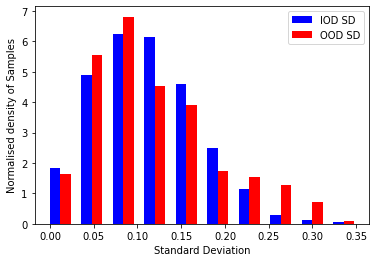

In [40]:
sd_test_IOD_df = pd.DataFrame(sd_test_IOD)
sd_test_OOD_df = pd.DataFrame(sd_test_OOD)
new_scores = np.concatenate([sd_test_IOD_df[col_no], sd_test_OOD_df[col_no]], axis=0)
minmaxscaler = MinMaxScaler()
new_scores_scaled = minmaxscaler.fit_transform(new_scores.reshape(-1, 1))

new_labels = np.concatenate([np.zeros_like(sd_test_IOD_df[col_no]), np.ones_like(sd_test_OOD_df[col_no])], axis=0)
histogram_df = pd.DataFrame(new_scores_scaled, new_labels)

#histogram_df.hist(column=0)

#sd_test_IOD_df.hist(column=0)
#sd_test_OOD_df.hist(column=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(sd_test_IOD_df[col_no].values.reshape(-1, 1), density=True)
b_heights, b_bins = np.histogram(sd_test_OOD_df[col_no].values.reshape(-1, 1), bins=a_bins, density=True)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width = width, facecolor='blue',label="IOD SD")
ax.bar(b_bins[:-1]+width, b_heights, width = width, facecolor='red', label="OOD SD")
ax.legend()
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Normalised density of Samples")
fig.savefig("density_vs_sd_dropout_iso_split_col_2.pdf")

0.5080716367461673


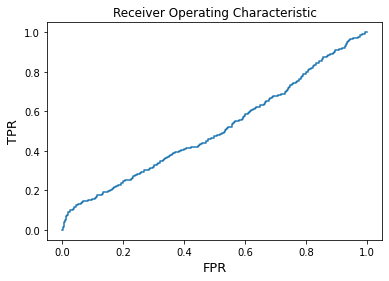

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score

norm_scores = new_scores - min(new_scores) / (max(new_scores) - min(new_scores))

auc = roc_auc_score(new_labels, new_scores)
fpr, tpr, threshs = roc_curve(new_labels, norm_scores, drop_intermediate=True)
print(auc)
plt.xlabel('FPR', fontsize=13)
plt.ylabel('TPR', fontsize=13)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.savefig("auc_dropout_iso_split_col_2.pdf")
plt.show()
